## 01. Library import

**Purpose**: Import core analytics and visualization stack, enable clean display, 

and record environment versions for reproducibility.

In [1]:
import os, sys, gc, json, textwrap, platform
from pathlib import Path
from glob import glob
from typing import List, Optional, Iterable, Dict

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

VERSIONS = {
    "python": sys.version,
    "platform": platform.platform(),
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "pyarrow": pa.__version__,
}
VERSIONS

{'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]',
 'platform': 'Windows-10-10.0.19045-SP0',
 'pandas': '2.2.2',
 'numpy': '1.26.4',
 'pyarrow': '21.0.0'}

## 02. Paths & config

**Purpose**: Define project folders, input patterns, and core options for controlled IO and memory usage.

In [2]:
PROJ_DIR = Path.cwd().resolve().parent if (Path.cwd() / "notebooks").exists() else Path.cwd()
DATA_DIR = (PROJ_DIR / "../data/train-data").resolve()
ARTIFACTS_DIR = (PROJ_DIR / "../artifacts").resolve()
REPORTS_DIR = (PROJ_DIR / "../reports").resolve()

for p in [DATA_DIR, ARTIFACTS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

PARQUET_GLOB = str(DATA_DIR / "*.pq")
SAMPLE_N_ROWS = 100_000   # used only when sampling large files
TARGET_COL = "target"     # placeholder; will be attached later in 03 notebook

CONFIG = {
    "read_engine": "pyarrow",     # pyarrow | fastparquet
    "low_memory": True,
    "sample_n_rows": SAMPLE_N_ROWS,
    "use_columns": None,          # e.g. ["id", "rn", "pre_loans_outstanding", ...]
}

## 03. Data file discovery

**Purpose**: Enumerate parquet files, estimate raw size footprint, and select a representative sample file for EDA.

In [3]:
files = sorted(glob(PARQUET_GLOB, recursive=True))
assert len(files) > 0, f"No parquet files found under {DATA_DIR}."

sizes = {f: Path(f).stat().st_size for f in files}
total_gb = sum(sizes.values()) / (1024**3)
sample_file = max(files, key=lambda f: sizes[f])  # pick largest as worst-case
{"n_files": len(files), "total_gb": round(total_gb, 3), "sample_file": sample_file}

{'n_files': 12,
 'total_gb': 0.376,
 'sample_file': 'D:\\final_v2\\credit-risk-management\\data\\train-data\\train_data_11.pq'}

## 04. First look: read 1 parquet

**Purpose**: Read a single parquet fully (if feasible) or sample rows to inspect schema and content.

In [4]:
def read_parquet_safe(path: str, use_columns: Optional[List[str]] = None,
sample_n: Optional[int] = None) -> pd.DataFrame:
    # Prefer pyarrow for stability; convert to pandas with safe types.
    pqf = pq.ParquetFile(path)
    if sample_n:
        # Row-group level sampling to avoid full scan;
        # fallback to head if row group metadata absent.
        if pqf.metadata and pqf.metadata.num_row_groups > 0:
            # read first row group or partial scan
            tbl = pqf.read_row_group(0, columns=use_columns)
            df = tbl.to_pandas(types_mapper=pd.ArrowDtype)
            return df.head(sample_n).copy()
    tbl = pq.read_table(path, columns=use_columns)
    return tbl.to_pandas(types_mapper=pd.ArrowDtype)

sample_df = read_parquet_safe(
    sample_file,
    use_columns=CONFIG["use_columns"],
    sample_n=CONFIG["sample_n_rows"]
    )
sample_df.shape, sample_df.head(3)

((100000, 61),
         id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
 0  2750000   1                 2                    2          2         14               12               11                       3   
 1  2750000   2                 1                    2         14          7               10                8                      10   
 2  2750000   3                 9                    2          4          8                1               11                      14   
 
    pre_loans_next_pay_summ  pre_loans_outstanding  pre_loans_total_overdue  pre_loans_max_overdue_sum  pre_loans_credit_cost_rate  pre_loans5  pre_loans530  \
 0                        6                      3                        0                          2                          13           6            16   
 1                        1                      2                        0                          2         

## 05. Basic diagnostics

**Purpose**: Validate schema, detect obvious anomalies, and quantify sparsity early.

In [5]:
def basic_diagnostics(df: pd.DataFrame, top_k: int = 30) -> Dict[str, object]:
    null_rate = df.isna().mean().sort_values(ascending=False)
    nunique = df.nunique(dropna=False).sort_values(ascending=False)
    dtypes = df.dtypes.astype(str).to_dict()
    return {
        "n_rows": int(df.shape[0]),
        "n_cols": int(df.shape[1]),
        "null_top": null_rate.head(top_k),
        "nunique_top": nunique.head(top_k),
        "dtypes": dtypes,
    }

diag = basic_diagnostics(sample_df)
{
    "n_rows": diag["n_rows"], 
    "n_cols": diag["n_cols"],
    "null_top(head)": diag["null_top"].head(10).to_dict()
}

{'n_rows': 100000,
 'n_cols': 61,
 'null_top(head)': {'id': 0.0,
  'enc_paym_1': 0.0,
  'enc_paym_3': 0.0,
  'enc_paym_4': 0.0,
  'enc_paym_5': 0.0,
  'enc_paym_6': 0.0,
  'enc_paym_7': 0.0,
  'enc_paym_8': 0.0,
  'enc_paym_9': 0.0,
  'enc_paym_10': 0.0}}

## 06. Numeric / categorical split

**Purpose**: Split columns into numeric/categorical/binary buckets for focused EDA and later encoding strategy.

In [8]:
num_cols = [c for c in sample_df.columns if pd.api.types.is_numeric_dtype(sample_df[c])]
cat_cols = [c for c in sample_df.columns if (not pd.api.types.is_numeric_dtype(sample_df[c])) or ("enc_" in c)]
bin_cols = [
    c for c in sample_df.columns 
    if pd.api.types.is_numeric_dtype(sample_df[c]) 
    and sample_df[c].dropna().astype(int).isin([0,1]).all()
]

summary = {
    "num_cols": len(num_cols),
    "cat_cols": len(cat_cols),
    "bin_cols": len(bin_cols),
}
summary, {"num_example": num_cols[:10], "cat_example": cat_cols[:10], "bin_example": bin_cols[:10]}

({'num_cols': 61, 'cat_cols': 29, 'bin_cols': 11},
 {'num_example': ['id',
   'rn',
   'pre_since_opened',
   'pre_since_confirmed',
   'pre_pterm',
   'pre_fterm',
   'pre_till_pclose',
   'pre_till_fclose',
   'pre_loans_credit_limit',
   'pre_loans_next_pay_summ'],
  'cat_example': ['enc_paym_0',
   'enc_paym_1',
   'enc_paym_2',
   'enc_paym_3',
   'enc_paym_4',
   'enc_paym_5',
   'enc_paym_6',
   'enc_paym_7',
   'enc_paym_8',
   'enc_paym_9'],
  'bin_example': ['pre_loans_total_overdue',
   'is_zero_loans5',
   'is_zero_loans530',
   'is_zero_loans3060',
   'is_zero_loans6090',
   'is_zero_loans90',
   'is_zero_util',
   'is_zero_over2limit',
   'is_zero_maxover2limit',
   'pclose_flag']})

## 07. Descriptives: numeric

**Purpose**: Compute robust numeric stats; clip quantiles to mitigate heavy tails and spot outliers.

In [9]:
desc_num = sample_df[num_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
desc_num.head(12)

,count,mean,std,min,1%,5%,50%,95%,99%,max
id,"100,000.0000","2,755,437.1571","3,143.0451","2,750,000.0000","2,750,107.0000","2,750,541.0000","2,755,463.0000","2,760,272.0000","2,760,681.0000","2,760,795.0000"
rn,"100,000.0000",7.2921,5.4839,1.0000,1.0000,1.0000,6.0000,18.0000,24.0000,43.0000
pre_since_opened,"100,000.0000",9.5325,5.8348,0.0000,0.0000,0.0000,10.0000,18.0000,19.0000,19.0000
pre_since_confirmed,"100,000.0000",8.6816,4.9237,0.0000,0.0000,1.0000,9.0000,17.0000,17.0000,17.0000
pre_pterm,"100,000.0000",8.3228,5.3577,0.0000,0.0000,0.0000,8.0000,17.0000,17.0000,17.0000
pre_fterm,"100,000.0000",8.3233,4.5133,0.0000,0.0000,0.0000,8.0000,16.0000,16.0000,16.0000
pre_till_pclose,"100,000.0000",7.1613,5.1233,0.0000,0.0000,0.0000,7.0000,15.0000,16.0000,16.0000
pre_till_fclose,"100,000.0000",8.3543,4.2466,0.0000,0.0000,1.0000,10.0000,14.0000,15.0000,15.0000
pre_loans_credit_limit,"100,000.0000",9.6641,5.8356,0.0000,0.0000,0.0000,10.0000,19.0000,19.0000,19.0000
pre_loans_next_pay_summ,"100,000.0000",2.3445,1.2748,0.0000,0.0000,0.0000,2.0000,5.0000,6.0000,6.0000


## 08. Descriptives: categorical snapshot

**Purpose**: Quick cardinality / top values to inform encoding and leakage checks.

In [10]:
def cat_profile(df: pd.DataFrame, cols: List[str], top_k: int = 10) -> pd.DataFrame:
    rows = []
    for c in cols:
        vc = df[c].value_counts(dropna=False)
        rows.append({
            "col": c,
            "nunique": int(df[c].nunique(dropna=False)),
            "top_values": ", ".join([f"{str(k)}:{int(v)}" for k, v in vc.head(top_k).items()])
        })
    return pd.DataFrame(rows).sort_values("nunique", ascending=False)

cat_snapshot = cat_profile(sample_df, cat_cols[: min(30, len(cat_cols))], top_k=5)
cat_snapshot.head(15)

,col,nunique,top_values
27,enc_loans_credit_type,8,"4:56038, 3:30148, 5:4638, 0:3303, 7:2454"
26,enc_loans_credit_status,7,"3:66661, 2:32298, 4:681, 1:185, 5:142"
25,enc_loans_account_holder_type,6,"1:98518, 3:925, 4:467, 6:75, 5:12"
0,enc_paym_0,4,"0:92576, 3:4362, 1:2849, 2:213"
15,enc_paym_15,4,"3:67241, 0:30747, 1:1860, 2:152"
24,enc_paym_24,4,"4:83225, 1:15710, 2:946, 3:119"
23,enc_paym_23,4,"3:78575, 0:20065, 1:1235, 2:125"
22,enc_paym_22,4,"3:77391, 0:21111, 1:1376, 2:122"
21,enc_paym_21,4,"3:76214, 0:22213, 1:1438, 2:135"
20,enc_paym_20,4,"4:75081, 1:23297, 2:1491, 3:131"


## 09. Memory report

**Purpose**: Estimate per-column memory to guide column pruning and dtype downcasting strategies.

In [11]:
def mem_report(df: pd.DataFrame) -> pd.DataFrame:
    out = (df.memory_usage(deep=True)
             .rename("bytes")
             .reset_index()
             .rename(columns={"index": "column"}))
    out["mb"] = out["bytes"] / (1024**2)
    return out.sort_values("mb", ascending=False)

mem_df = mem_report(sample_df)
mem_df.head(20)

,column,bytes,mb
31,enc_paym_0,812500,0.7749
46,enc_paym_15,812500,0.7749
33,enc_paym_2,812500,0.7749
34,enc_paym_3,812500,0.7749
35,enc_paym_4,812500,0.7749
36,enc_paym_5,812500,0.7749
37,enc_paym_6,812500,0.7749
38,enc_paym_7,812500,0.7749
39,enc_paym_8,812500,0.7749
40,enc_paym_9,812500,0.7749


## 10. Batch reader utility

**Purpose**: Read multiple parquet files iteratively with column selection and row-wise processing callback.

In [12]:
def iter_parquet_files(paths: Iterable[str]) -> Iterable[str]:
    for p in paths:
        if p.endswith(".parquet"):
            yield p

def batch_read_parquet(
    paths: Iterable[str],
    use_columns: Optional[List[str]] = None,
    row_fn: Optional[callable] = None,
    concat: bool = True,
    limit_files: Optional[int] = None,
) -> pd.DataFrame:
    frames = []
    for i, path in enumerate(tqdm(iter_parquet_files(paths), total=None, desc="Reading parquet files")):
        if limit_files is not None and i >= limit_files:
            break
        df = read_parquet_safe(path, use_columns=use_columns, sample_n=None)
        if row_fn is not None:
            df = row_fn(df)
        frames.append(df)
        if not concat:
            yield df
            frames.pop()
        else:
            # Periodic GC to bound memory usage
            if sum(f.memory_usage(deep=True).sum() for f in frames) > 1.5 * (1024**3):  # >1.5GB
                frames = [pd.concat(frames, ignore_index=True)]
                gc.collect()
    if concat:
        return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

# dry-run over first 2 files (no concatenation) to validate the pipeline quickly
_ = list(batch_read_parquet(files, use_columns=CONFIG["use_columns"], row_fn=None, concat=False, limit_files=2))
print("Batch util: OK")

Reading parquet files: 0it [00:00, ?it/s]

Batch util: OK


## 11. Quick EDA visuals

**Purpose**: Render lightweight plots for distributions, correlations, and missingness patterns.

**Notes**: `For huge frames prefer sampling to avoid slow rendering.`

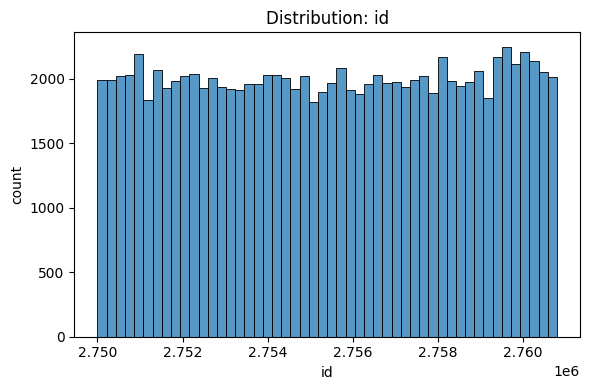

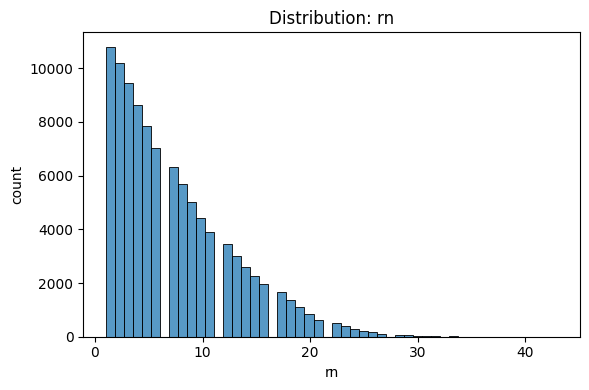

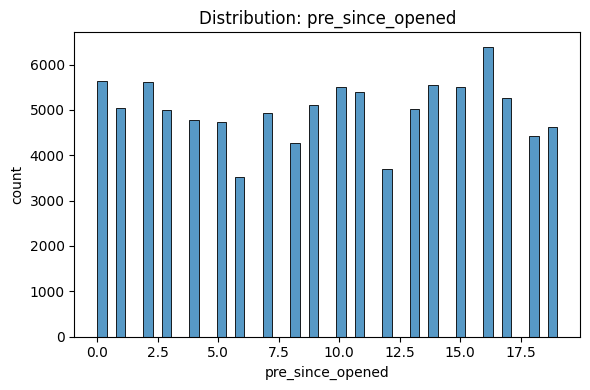

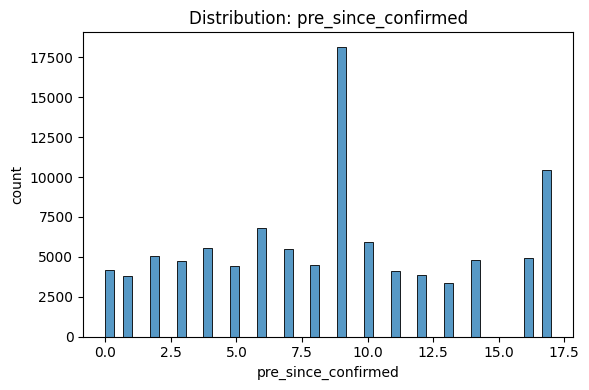

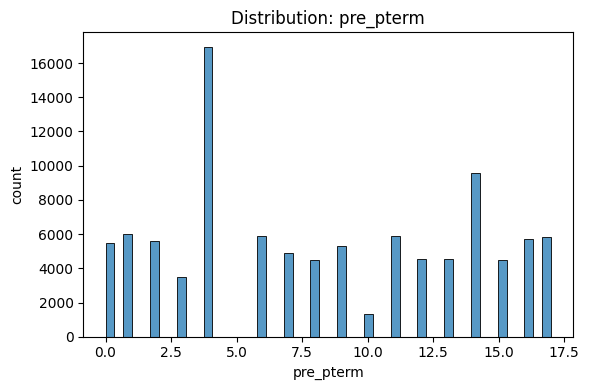

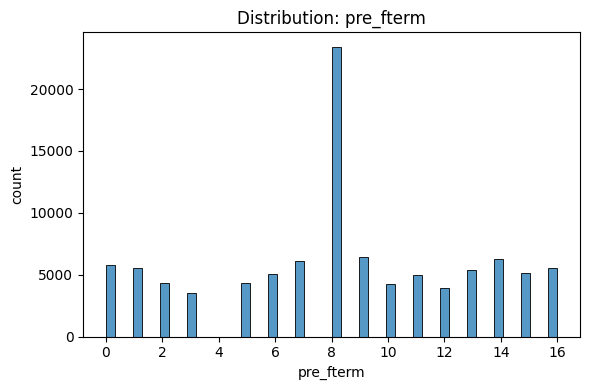

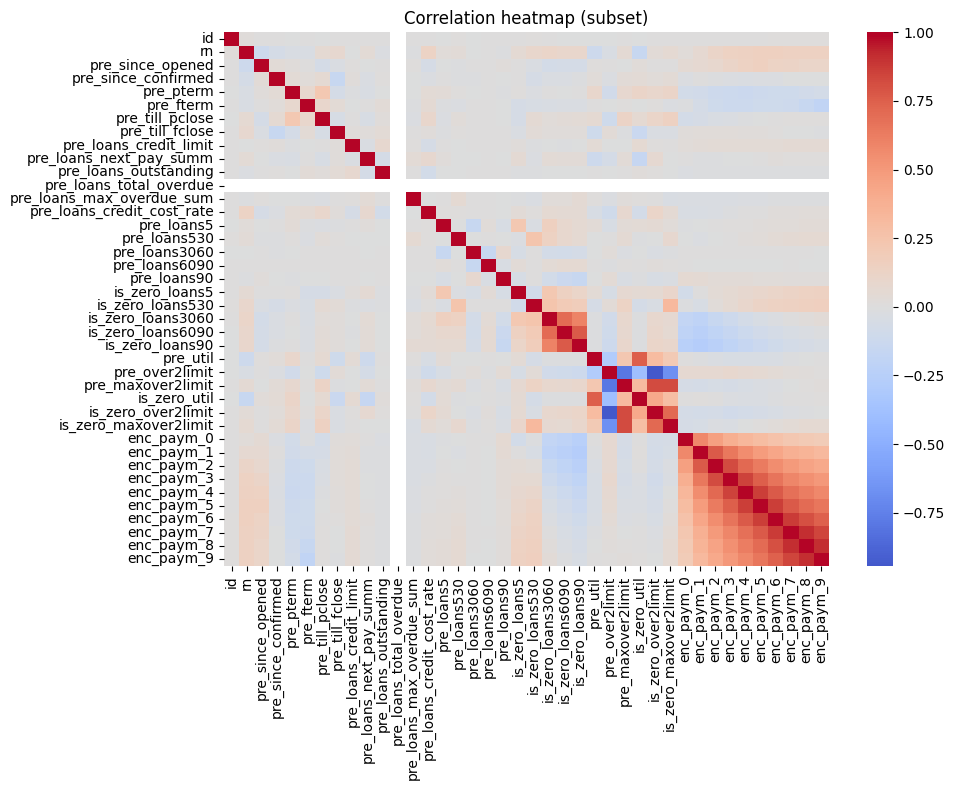

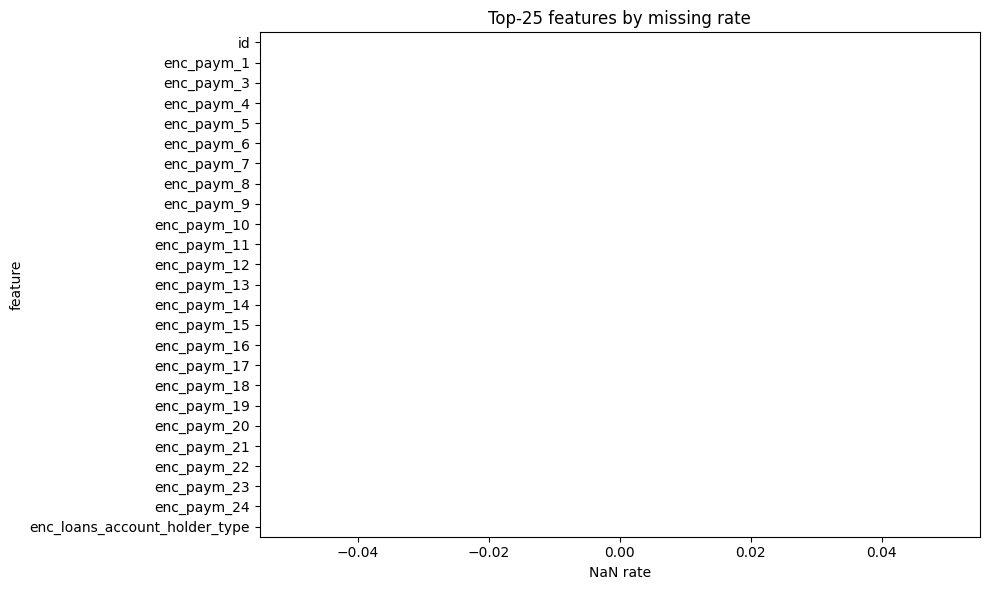

In [13]:
PLOT_SAMPLE = min(len(sample_df), 100_000)
plot_df = sample_df.sample(PLOT_SAMPLE, random_state=42) if len(sample_df) > PLOT_SAMPLE else sample_df

# histogram(s) for a few numeric columns
cols_to_plot = num_cols[:6]
n = len(cols_to_plot)
for c in cols_to_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(plot_df[c].dropna(), bins=50)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c); plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# correlation heatmap (numeric only; clipped to first N columns for readability)
corr_cols = num_cols[:40]
corr = plot_df[corr_cols].corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, square=False)
plt.title("Correlation heatmap (subset)")
plt.tight_layout()
plt.show()

# missingness bar for top missing columns
null_rate = sample_df.isna().mean().sort_values(ascending=False).head(25)
plt.figure(figsize=(10,6))
sns.barplot(x=null_rate.values, y=null_rate.index)
plt.xlabel("NaN rate")
plt.ylabel("feature")
plt.title("Top-25 features by missing rate")
plt.tight_layout()
plt.show()

## 12. EDA notes & save

**Purpose**: Persist compact EDA summary for traceability and downstream discussions.

In [14]:
eda_summary = {
    "versions": VERSIONS,
    "n_files": len(files),
    "total_size_gb": float(round(total_gb, 3)),
    "sample_file": sample_file,
    "shape": {"rows": int(sample_df.shape[0]), "cols": int(sample_df.shape[1])},
    "num_cols": len(num_cols),
    "cat_cols": len(cat_cols),
    "bin_cols": len(bin_cols),
    "top_missing": {k: float(v) for k, v in sample_df.isna().mean().sort_values(ascending=False).head(20).to_dict().items()},
}
(REPORTS_DIR / "eda_summary.json").write_text(json.dumps(eda_summary, indent=2, ensure_ascii=False))
print(f"Saved: {REPORTS_DIR / 'eda_summary.json'}")

Saved: D:\final_v2\credit-risk-management\reports\eda_summary.json


## 13. Cleanup

**Purspose**: Release memory held by large intermediates to keep the kernel responsive.

In [15]:
del plot_df, corr, mem_df, cat_snapshot, desc_num
gc.collect()
print("Cleanup done.")

Cleanup done.


## 14. Trial feature frame (curated)

**Purpose**: Materialize a curated trial dataframe using a balanced subset of features across semantic groups for baseline readiness.

In [17]:
# Rehydrate sample_df if this cell is run standalone
try:
    _ = sample_df.shape
except NameError:
    sample_df = read_parquet_safe(sample_file, use_columns=CONFIG.get("use_columns"), sample_n=CONFIG.get("sample_n_rows"))

# --- Column groups (ordered by priority) ---
ident_cols = ["id", "rn"]

# financial magnitudes
financial_cols = [
    "pre_loans_credit_limit",
    "pre_loans_next_pay_summ",
    "pre_loans_outstanding",
    "pre_loans_total_overdue",
    "pre_loans_max_overdue_sum",
    "pre_loans_credit_cost_rate",
]

# delinquency counts and zero-flags
delinq_count_cols = ["pre_loans5", "pre_loans530", "pre_loans3060", "pre_loans6090", "pre_loans90"]
delinq_zero_flags = ["is_zero_loans5", "is_zero_loans530", "is_zero_loans3060", "is_zero_loans6090", "is_zero_loans90"]

# engineered ratios (keep for baseline; will be recomputed/validated later)
ratio_cols = ["pre_util", "pre_over2limit", "pre_maxover2limit", "is_zero_util", "is_zero_over2limit", "is_zero_maxover2limit"]

# temporal subset (lightweight sample)
temporal_cols = ["pre_since_opened", "pre_pterm", "pre_till_pclose"]

# payment history (first 5 months as a compact proxy)
paym_cols = [f"enc_paym_{i}" for i in range(5)]

# categorical encodings
cat_enc_cols = [
    "enc_loans_account_holder_type",
    "enc_loans_credit_status",
    "enc_loans_credit_type",
    "enc_loans_account_cur",
]

# close flags
close_flags = ["pclose_flag", "fclose_flag"]

# --- Keep columns that actually exist in the current data ---
def keep_existing(cols):
    return [c for c in cols if c in sample_df.columns]

ordered_groups = [
    keep_existing(ident_cols),
    keep_existing(financial_cols),
    keep_existing(delinq_count_cols),
    keep_existing(delinq_zero_flags),
    keep_existing(ratio_cols),
    keep_existing(temporal_cols),
    keep_existing(paym_cols),
    keep_existing(cat_enc_cols),
    keep_existing(close_flags),
]

# Preserve order and deduplicate
trial_cols = []
for grp in ordered_groups:
    for c in grp:
        if c not in trial_cols:
            trial_cols.append(c)

assert len(trial_cols) > 0, "No trial columns found. Check the dataset schema."

# --- Build and persist the curated trial frame ---
TRIAL_ROWS = 1_000
trial_df = sample_df[trial_cols].head(TRIAL_ROWS).copy()

summary = {
    "shape": trial_df.shape,
    "n_cols": len(trial_cols),
    "columns": trial_cols,
    "null_rate_top": trial_df.isna().mean().sort_values(ascending=False).head(10).to_dict(),
}
print(json.dumps(summary, indent=2, ensure_ascii=False))

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
trial_parquet = ARTIFACTS_DIR / "trial_feature_frame.parquet"
trial_csv = ARTIFACTS_DIR / "trial_feature_frame.csv"
trial_df.to_parquet(trial_parquet, index=False)
trial_df.to_csv(trial_csv, index=False)
print(f"Saved trial frames:\n- {trial_parquet}\n- {trial_csv}")

display(trial_df.head(10))

{
  "shape": [
    1000,
    38
  ],
  "n_cols": 38,
  "columns": [
    "id",
    "rn",
    "pre_loans_credit_limit",
    "pre_loans_next_pay_summ",
    "pre_loans_outstanding",
    "pre_loans_total_overdue",
    "pre_loans_max_overdue_sum",
    "pre_loans_credit_cost_rate",
    "pre_loans5",
    "pre_loans530",
    "pre_loans3060",
    "pre_loans6090",
    "pre_loans90",
    "is_zero_loans5",
    "is_zero_loans530",
    "is_zero_loans3060",
    "is_zero_loans6090",
    "is_zero_loans90",
    "pre_util",
    "pre_over2limit",
    "pre_maxover2limit",
    "is_zero_util",
    "is_zero_over2limit",
    "is_zero_maxover2limit",
    "pre_since_opened",
    "pre_pterm",
    "pre_till_pclose",
    "enc_paym_0",
    "enc_paym_1",
    "enc_paym_2",
    "enc_paym_3",
    "enc_paym_4",
    "enc_loans_account_holder_type",
    "enc_loans_credit_status",
    "enc_loans_credit_type",
    "enc_loans_account_cur",
    "pclose_flag",
    "fclose_flag"
  ],
  "null_rate_top": {
    "id": 0.0,
    "enc_p

,id,rn,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pre_since_opened,pre_pterm,pre_till_pclose,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,2750000,1,3,6,3,0,2,13,6,16,5,4,8,1,0,1,1,1,12,2,17,0,1,1,2,2,12,0,0,1,0,0,1,2,4,1,0,0
1,2750000,2,10,1,2,0,2,1,6,16,5,4,8,1,1,1,1,1,11,2,17,0,1,1,1,14,10,0,0,0,0,0,1,2,3,1,0,0
2,2750000,3,14,2,3,0,2,3,6,16,5,4,8,1,1,1,1,1,9,5,4,0,0,0,9,4,1,0,0,0,0,0,1,2,3,1,1,1
3,2750000,4,9,3,5,0,2,0,6,16,5,4,8,1,0,1,1,1,11,2,17,0,1,1,9,11,14,0,0,1,0,0,1,2,4,1,0,0
4,2750000,5,4,2,3,0,2,2,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,9,6,0,0,0,0,0,0,1,2,3,1,0,0
5,2750000,6,11,4,5,0,2,3,6,16,5,4,8,1,0,1,1,1,18,2,17,0,1,1,9,14,10,0,0,0,0,1,1,2,4,1,0,0
6,2750000,7,5,6,3,0,2,3,6,16,5,4,8,1,1,1,1,1,10,2,17,0,1,1,7,15,12,0,0,0,0,0,1,2,7,1,0,1
7,2750001,1,5,2,3,0,2,2,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,15,7,9,0,0,0,0,0,1,3,4,1,0,0
8,2750001,2,14,2,3,0,2,2,6,16,5,4,8,1,1,1,1,1,9,5,4,0,0,0,15,6,0,0,3,3,3,3,1,3,3,1,0,0
9,2750001,3,14,2,3,0,2,2,6,16,5,4,8,1,1,1,1,1,9,5,4,0,0,0,14,6,0,0,0,3,3,3,1,2,3,1,0,0
